In [1]:
import numpy as np 
import torch
import torch.nn as nn

### 1. Pytorch for automatic differentiation
- Elegant design principle: computation graph created dynamically as you specify the forward pass.
- Pytorch keeps track of which operations have performed, and then it replays them backward to compute the gradients.

Let's use computation graph #2 from last class: 
$$ f(x, y, z, w) = 2 (xy + \max(z, w))$$ 

Input values: $x = 3, y = -4, z = 2, w = -1$

In [2]:
# Tensor is the main datastructure 
xyzw = torch.tensor([3.0, -4.0, 2.0, -1.0], requires_grad=True) 
#requires_grad=True tells Pytorch that we want to backprop thru these variables

In [3]:
# Forward pass: Calculates the function 
a = xyzw[0]*xyzw[1]
b = torch.max(xyzw[2], xyzw[3])
f = 2*(a+b)

In [4]:
print(f)

tensor(-20., grad_fn=<MulBackward0>)


In [5]:
f.backward() #Tell Pytorch to do the backwards pass through the computation graph 

In [6]:
# Partial derivatives of f with respect to each element
# in vector xyzw
print(xyzw.grad)

tensor([-8.,  6.,  2.,  0.])


Change inputs and everything is easy to get the partial derivatives! 

In [7]:
xyzw = torch.tensor([1.0, 2.0, 3.0, -1.0], requires_grad=True) 

In [8]:
a = xyzw[0]*xyzw[1]
b = torch.max(xyzw[2], xyzw[3])
f = 2*(a+b)
print(f)

tensor(10., grad_fn=<MulBackward0>)


In [9]:
f.backward()
print(xyzw.grad)

tensor([4., 2., 2., 0.])


Visualize the computation graph

In [10]:
#!pip install torchviz

In [11]:
from torchviz import make_dot

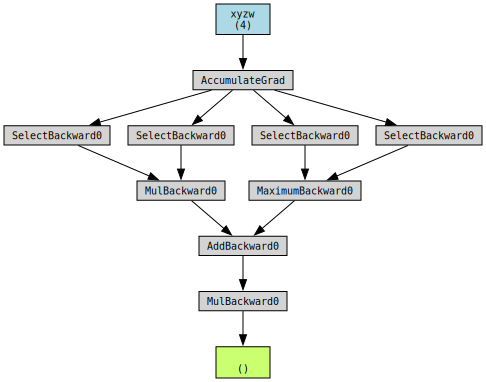

In [12]:
make_dot(f, params={'xyzw': xyzw})

We can modify the forward pass and everything is easy! 

In [13]:
a = xyzw[0]*xyzw[1]+5
b = torch.max(xyzw[2], xyzw[3])
f2 = 2*(a*b)
print(f2)

tensor(42., grad_fn=<MulBackward0>)


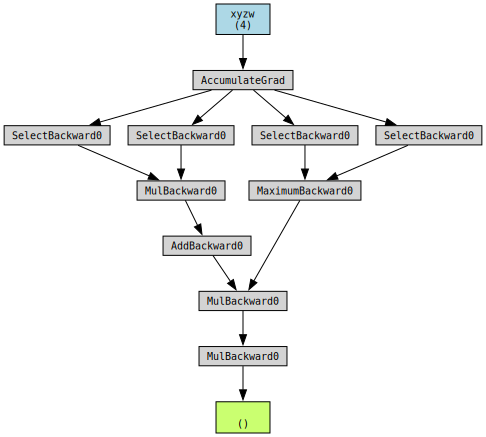

In [14]:
make_dot(f2, params={'xyzw': xyzw})

### 2. Pytorch for training

In [15]:
# Training Data 
NUM_CLASSES = 2 #let's do binary logistic regression again 

# Rows: Examples 
# Columns: Features 
X_train = torch.tensor([[1.0, 0.0, 0.0], 
                        [0.0, 1.0, 1.0], 
                        [1.0, 1.0, 0.0], 
                        [0.0, 0.0, 1.0]])

Y_train = torch.tensor([0, 1, 0, 1])

num_examples = X_train.shape[0]
num_features = X_train.shape[1]

assert X_train.shape[0] == Y_train.shape[0]

In [16]:
class FeedForward1Hidden(nn.Module):
    """
    Pytorch implementation for single hidden layer deep learning model 
    """
    def __init__(self, num_features, num_classes, w1_dim):
        super().__init__()
        self.W1 = nn.Linear(num_features, w1_dim)
        self.W2 = nn.Linear(w1_dim, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, X):
        hidden1 = nn.functional.relu(self.W1(X))
        out = self.W2(hidden1)
        log_probs = self.log_softmax(out)
        return log_probs
        
    def predict(self, X): 
        self.eval()
        log_probs = self.forward(X)
        log_probs_numpy = log_probs.detach().numpy()
        pred_pos_class = np.exp(log_probs_numpy)[:, 1]
        y_pred = (pred_pos_class > 0.5).astype(int)
        return y_pred, pred_pos_class    
    
    def train_model(self, X, Y, loss_fn, optimizer, num_iterations): 
        """
        Training our binary logistic regression model 

        Note: Here, we are not using mini-batches, we are going through the entire
            dataset in every iteration (not recommended beyond toy examples)
        """
        self.train() # tells nn.Module its in training mode 
                      # (important when we get to things like dropout)

        for t in range(num_iterations): 
            # Forward pass 
            pred = self.forward(X)
            loss = loss_fn(pred, Y)

            #Backprop
            optimizer.zero_grad() # clears the gradients from the previous iteration
                                  # this step is important because otherwise Pytorch will 
                                  # *accumulate* gradients for all itereations (all backwards passes)
            loss.backward() # calculate gradients from forward step 
            optimizer.step() # gradient descent update equation 

            loss_value = loss.item() # call .item() to detach from the tensor 
            print(f"Iteration={t}, Loss={loss_value}") 

In [17]:
W1_DIM = 2
model_ff = FeedForward1Hidden(num_features, NUM_CLASSES, W1_DIM) #initalize
model_ff

FeedForward1Hidden(
  (W1): Linear(in_features=3, out_features=2, bias=True)
  (W2): Linear(in_features=2, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [18]:
X_test = torch.tensor([[1.0, 0.0, 0.0]])

In [19]:
y_pred, pred_pos_class = model_ff.predict(X_test)

In [20]:
# Training decisions
LEARNING_RATE = 1e-3
NUMBER_ITERATIONS = 10 
loss_fn= nn.NLLLoss() #choose our loss function 

In [21]:
# Training 
optimizer = torch.optim.SGD(model_ff.parameters(), lr=LEARNING_RATE)
model_ff.train_model(X_train, Y_train, loss_fn, optimizer, NUMBER_ITERATIONS)

Iteration=0, Loss=0.8666473627090454
Iteration=1, Loss=0.8664203882217407
Iteration=2, Loss=0.8661936521530151
Iteration=3, Loss=0.8659673929214478
Iteration=4, Loss=0.8657413721084595
Iteration=5, Loss=0.8655157089233398
Iteration=6, Loss=0.8652902841567993
Iteration=7, Loss=0.865065336227417
Iteration=8, Loss=0.8648406863212585
Iteration=9, Loss=0.8646162748336792


### 3. Adding dropout

In [22]:
class FeedForward1Hidden(nn.Module):
    """
    Pytorch implementation for single hidden layer deep learning model 
    """
    def __init__(self, num_features, num_classes, w1_dim, dropout_probability):
        super().__init__()
        self.W1 = nn.Linear(num_features, w1_dim)
        self.W2 = nn.Linear(w1_dim, num_classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        self.dropout = nn.Dropout(dropout_probability) #another hyperparameter
        
    def forward(self, X):
        hidden1 = nn.functional.relu(self.W1(X))
        hidden1 = self.dropout(hidden1) #dropout added here 
        out = self.W2(hidden1)
        log_probs = self.log_softmax(out)
        return log_probs
        
    def predict(self, X): 
        self.eval()
        log_probs = self.forward(X)
        log_probs_numpy = log_probs.detach().numpy()
        pred_pos_class = np.exp(log_probs_numpy)[:, 1]
        y_pred = (pred_pos_class > 0.5).astype(int)
        return y_pred, pred_pos_class    
    
    def train_model(self, X, Y, loss_fn, optimizer, num_iterations): 
        """
        Training our binary logistic regression model 

        Note: Here, we are not using mini-batches, we are going through the entire
            dataset in every iteration (not recommended beyond toy examples)
        """
        self.train() # tells nn.Module its in training mode 
                      # (important when we get to things like dropout)

        for t in range(num_iterations): 
            # Forward pass 
            pred = self.forward(X)
            loss = loss_fn(pred, Y)

            #Backprop
            optimizer.zero_grad() # clears the gradients from the previous iteration
                                  # this step is important because otherwise Pytorch will 
                                  # *accumulate* gradients for all itereations (all backwards passes)
            loss.backward() # calculate gradients from forward step 
            optimizer.step() # gradient descent update equation 

            loss_value = loss.item() # call .item() to detach from the tensor 
            print(f"Iteration={t}, Loss={loss_value}") 

### 4. Adam optimizer

In [23]:
LEARNING_RATE = 1e-3
BETA1 = 0.9
BETA2 = 0.99

optimizer = torch.optim.Adam(model_ff.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
model_ff.train_model(X_train, Y_train, loss_fn, optimizer, NUMBER_ITERATIONS)

Iteration=0, Loss=0.8643922209739685
Iteration=1, Loss=0.8630701899528503
Iteration=2, Loss=0.8617547750473022
Iteration=3, Loss=0.8604459762573242
Iteration=4, Loss=0.8591439723968506
Iteration=5, Loss=0.8578487634658813
Iteration=6, Loss=0.856560468673706
Iteration=7, Loss=0.8552792072296143
Iteration=8, Loss=0.854004979133606
Iteration=9, Loss=0.8527380228042603
